In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("scaled_average_daily_data.csv")

In [3]:
df.columns

Index(['Unnamed: 0', 'time', 'P', 'Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m',
       'WS10m'],
      dtype='object')

In [4]:
df['time'] = pd.to_datetime(df['time'])  # Convert the 'time' column to datetime
df.set_index('time', inplace=True)  # Set the 'time' column as the index

In [5]:
print(df.head())

            Unnamed: 0           P       Gb(i)      Gd(i)     Gr(i)  \
time                                                                  
2014-12-31           0    0.000000    0.000000   0.000000  0.000000   
2015-01-01           1  116.412500   70.378333  86.086667  0.483750   
2015-01-02           2  209.844167  198.838333  78.765417  0.803333   
2015-01-03           3  197.027917  174.022500  88.432083  0.769583   
2015-01-04           4  203.748333  191.975000  80.451667  0.793750   

                H_sun        T2m     WS10m  
time                                        
2014-12-31   0.000000  22.680000  1.380000  
2015-01-01  15.396250  25.336250  2.053333  
2015-01-02  15.422083  25.612917  2.629583  
2015-01-03  15.448333  25.226250  1.760833  
2015-01-04  15.477917  25.299583  2.025000  


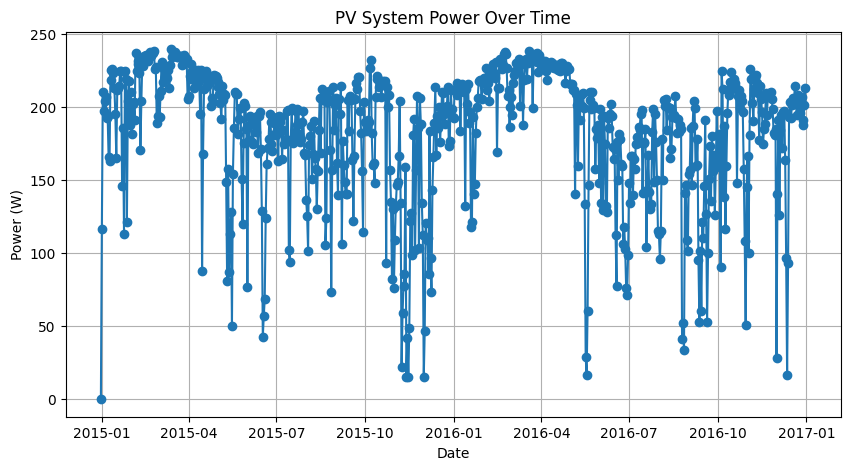

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df['P'], marker='o')
plt.title('PV System Power Over Time')
plt.xlabel('Date')
plt.ylabel('Power (W)')
plt.grid()
plt.show()

In [7]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:', key, value)

In [8]:
check_stationarity(df['P'])

ADF Statistic: -5.202576636715629
p-value: 8.686212462205248e-06
Critical Values: 1% -3.4394144152232995
Critical Values: 5% -2.8655403100177566
Critical Values: 10% -2.5689002207655443


In [9]:
df['P_diff'] = df['P'].diff().dropna()

In [10]:
check_stationarity(df['P_diff'].dropna())

ADF Statistic: -11.008369342850058
p-value: 6.417888504993322e-20
Critical Values: 1% -3.439516060164992
Critical Values: 5% -2.8655850998755263
Critical Values: 10% -2.5689240826597173


In [11]:
model = ARIMA(df['P'], order=(1, 1, 1))  # Adjust (p, d, q) as needed
model_fit = model.fit()

/Users/tejaswinithota/Desktop/solar_forecasting/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/tejaswinithota/Desktop/solar_forecasting/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/tejaswinithota/Desktop/solar_forecasting/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [12]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      P   No. Observations:                  732
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3595.125
Date:                Wed, 30 Oct 2024   AIC                           7196.250
Time:                        20:08:36   BIC                           7210.034
Sample:                    12-31-2014   HQIC                          7201.568
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5393      0.032     17.115      0.000       0.478       0.601
ma.L1         -0.9309      0.016    -58.908      0.000      -0.962      -0.900
sigma2      1093.3273     35.007     31.232      0.0

In [13]:
forecast = model_fit.forecast(steps=5)  # Forecast for the next 5 time steps
print('Forecasted Power:', forecast)

Forecasted Power: 2017-01-01    202.913781
2017-01-02    197.561020
2017-01-03    194.674013
2017-01-04    193.116907
2017-01-05    192.277083
Freq: D, Name: predicted_mean, dtype: float64


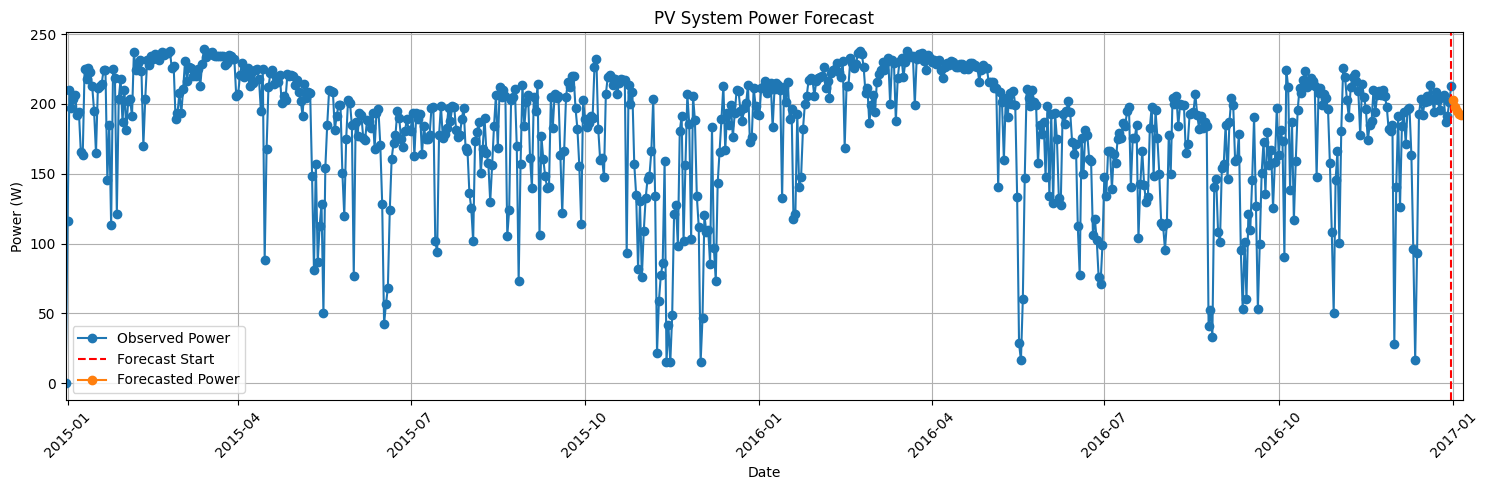

In [15]:
plt.figure(figsize=(15, 5))  # Increase the width of the figure
plt.plot(df['P'], label='Observed Power', marker='o')
plt.axvline(x=df.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.plot(pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=5), forecast, label='Forecasted Power', marker='o')

# Set x-axis limits for better visibility
plt.xlim([df.index[0], df.index[-1] + pd.Timedelta(days=6)])  # Adjust the limit to expand the view

plt.title('PV System Power Forecast')
plt.xlabel('Date')
plt.ylabel('Power (W)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-tick labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()